# CM4107 Advanced Artificial Intelligence 
## Coursework 2: Comparative Study
Comparative study of MLP, kNN and SVM from Scikit Learn Python library. Text Classification of two datasets, IMDB Movie Review and Spam Text Messages. 

## Setup 

### Imports

In [199]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Regular Expressions 
import re

#Models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration Functions 

In [200]:
def DataExploration(dataset):
    print(dataset['data'].head())
    print(dataset['data'].columns.values)
    print(dataset['data'].shape)

### Pre-Processing Functions

In [201]:
#Regular Expressions to Clean Up the Text 
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

def tokenizer(text):
       return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]

def stop_removal(text):
       return [w for w in text if not w in stop]
    
def tokenizer_stemmer_stop_removal(text):
    return [w for w in tokenizer_stemmer(text) if w.lower() not in stop]



### Grid Search Cross Validation Functions 

In [202]:
def GridSearchCrossValidation(model_name, model, dataset_name, dataset):
    #Pipeline
    pipeline = make_pipeline(TfidfVectorizer(strip_accents=None,
                    lowercase=False,
                    min_df=7,
                    preprocessor=None),model)
    #Grid Search with Cross Validation 
    gs_tfidf = GridSearchCV(pipeline, {**param_grids['tfidf'],**param_grids[model_name]},
                       scoring='accuracy',
                       cv=3,
                       verbose=1,
                       n_jobs=1)
    #Set Variable 
    dataset[model_name+"_gs_tfidf"] = gs_tfidf.fit(dataset['text_train'],dataset['Y_train']) 
    #Show testing accuracies 
    print(dataset_name + " " + model_name + " Best Score: " + str(dataset[model_name+"_gs_tfidf"].best_score_))
    print(dataset_name + " " + model_name + " Best Params: " + str(dataset[model_name+"_gs_tfidf"].best_params_))

### Testing Functions 

In [203]:
def BestEstimatorScore(dataset,model_name):
    dataset[model_name+"_best_estimator_score"] = dataset[model_name+"_gs_tfidf"].best_estimator_.score(dataset['text_test'],dataset['Y_test'])
    print(dataset_name + " " + model_name + ": " + str(dataset[model_name+"_best_estimator_score"]))

def ClassificationReport(dataset,model_name):
    dataset[model_name+"_best_estimator_predictions"] = dataset[model_name+"_gs_tfidf"].best_estimator_.predict(dataset['text_test'])
    print(classification_report(dataset['Y_test'],dataset[model_name+"_best_estimator_predictions"]))

### Visualisation Functions 

In [204]:
def BarGraph(labels, dataset, dataset_name, y_pos, y_label):
    results = []
    for model_name in labels:
        results.append(dataset[model_name+"_best_estimator_score"])
    plt.bar(y_pos,results,align="center",alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel(y_label)
    plt.title(dataset_name + " Best Estimator Scores")

### Variables 

In [205]:
#Datasets 
datasets = {}
datasets['IMDB'] = {'data':None,'X':None,'Y':None,'text_train':None,'text_test':None,'Y_train':None,'Y_test':None}
datasets['spam'] = {'data':None,'X':None,'Y':None,'text_train':None,'text_test':None,'Y_train':None,'Y_test':None}
#File names
datasets['IMDB']['filename'] = 'datasets/movie_data_cat.csv'
datasets['spam']['filename'] = 'datasets/SMSSpamData.csv'
#Text Pre Processing
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
#Models
models = {}
models['MLP'] = MLPClassifier()
models['KNN'] = KNeighborsClassifier()
models['SVM'] = SVC(kernel='rbf', gamma=0.7, C=1.0)
#Grid Search Cross Validation Setup
#GridSearchCV Params
param_grids = {}
param_grids['tfidf'] = {'tfidfvectorizer__ngram_range': [(1, 1),(1,2),(1,3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'tfidfvectorizer__max_features': [1000, 4000], # use the stop dictionary of stopwords or not
               'tfidfvectorizer__tokenizer': [tokenizer_stemmer_stop_removal]}
param_grids['MLP'] = {'mlpclassifier__hidden_layer_sizes':[(10,),(20,),(30,),(40,),(50,)],
                     'mlpclassifier__learning_rate_init':[0.2,0.4,0.6,0.8,1.0]}
param_grids['KNN'] = {'kneighborsclassifier__weights':['uniform','distance'],
                     'kneighborsclassifier__n_neighbors':[2,5,10,15,20]}
param_grids['SVM'] = {'svc__C':[0.001,0.01,0.1,1,10],
                     'svc__gamma': [0.001,0.01,0.1,1],}

### Load Datasets 

#### Dataset 1: IMDB Movie Reviews

In [206]:
#IMDB
datasets['IMDB']['data'] = pd.read_csv(datasets['IMDB']['filename'])
#IMDB dataset is very large, to save time taking first 10,000 entries
### smaller sample
datasets['IMDB']['data'] = datasets['IMDB']['data'].loc[:10000,]

#### Dataset 2: Spam Text Messages 

In [207]:
#spam
datasets['spam']['data'] = pd.read_csv(datasets['spam']['filename'])

### Data Exploration 

#### Dataset 1: IMDB Movie Reviews

In [208]:
DataExploration(datasets['IMDB'])

                                              review sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...       pos
1  OK... so... I really like Kris Kristofferson a...       neg
2  ***SPOILER*** Do not read this, if you think a...       neg
3  hi for all the people who have seen this wonde...       pos
4  I recently bought the DVD, forgetting just how...       neg
['review' 'sentiment']
(10001, 2)


#### Dataset 2: Spam Text Messages 

In [209]:
DataExploration(datasets['spam'])

  class                                            sms_msg
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
['class' 'sms_msg']
(5574, 2)


### Pre-Processing 

#### Dataset 1: IMDB Movie Reviews

In [210]:
#Column Names
datasets['IMDB']['text_col_name'] = 'review'
datasets['IMDB']['class_col_name'] = 'sentiment'
#Class labels
datasets['IMDB']['data']['sentiment'] = datasets['IMDB']['data']['sentiment'].map({label:idx for idx,label in enumerate(np.unique(datasets['IMDB']['data']['sentiment']))})
#Regular Expression filter 
datasets['IMDB']['data']['review'] = datasets['IMDB']['data']['review'].apply(preprocessor)
#Split into X and Y
datasets['IMDB']['X'] = datasets['IMDB']['data'].loc[:, 'review'].values
datasets['IMDB']['Y'] = datasets['IMDB']['data'].loc[:, 'sentiment'].values 
#Split into Train and Test 
datasets['IMDB']['text_train'],datasets['IMDB']['text_test'],datasets['IMDB']['Y_train'],datasets['IMDB']['Y_test'] = train_test_split(datasets['IMDB']['X'],
                                         datasets['IMDB']['Y'],
                                         random_state=42,
                                         test_size=0.25,
                                         stratify=datasets['IMDB']['Y'])

#### Dataset 2: Spam Text Messages 

In [211]:
#Column Names
datasets['spam']['text_col_name'] = 'sms_msg'
datasets['spam']['class_col_name'] = 'class'
#Class labels
datasets['spam']['data']['class'] = datasets['spam']['data']['class'].map({label:idx for idx,label in enumerate(np.unique(datasets['spam']['data']['class']))})
#Regular Expression filter 
datasets['spam']['data']['sms_msg'] = datasets['spam']['data']['sms_msg'].apply(preprocessor)
#Split into X and Y
datasets['spam']['X'] = datasets['spam']['data'].loc[:, 'sms_msg'].values
datasets['spam']['Y'] = datasets['spam']['data'].loc[:, 'class'].values
#Split into Train and Test 
datasets['spam']['text_train'],datasets['spam']['text_test'],datasets['spam']['Y_train'],datasets['spam']['Y_test'] = train_test_split(datasets['spam']['X'],
                                         datasets['spam']['Y'],
                                         random_state=42,
                                         test_size=0.25,
                                         stratify=datasets['spam']['Y'])

## Training

### Grid Search Cross Validation for Each Model 

Grid search with cross validation to find the best parameter combinations for each model on each dataset. Pipeline that consists of a TfidfVectorizer and then one of the three models. TfidVectorizer combines CountVectorizer and TfidTransformer. CountVectorizer converts text rows into a matrix of token counts.TfidTransformer transforms a count matrix to a normalised term-frequency times inverse document-frequency representation.

#### Dataset 1: IMDB Movie Reviews

##### MLP

In [212]:
GridSearchCrossValidation("MLP", models['MLP'], "IMDB Movie Reviews", datasets['IMDB'])

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 248.2min finished


IMDB Movie Reviews MLP Best Score: 0.8330666666666666
IMDB Movie Reviews MLP Best Params: {'mlpclassifier__hidden_layer_sizes': (40,), 'mlpclassifier__learning_rate_init': 0.6, 'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer_stop_removal at 0x0000027684412C80>}


##### kNN

In [214]:
GridSearchCrossValidation("KNN", models['KNN'], "IMDB Movie Reviews", datasets['IMDB'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 101.6min finished


IMDB Movie Reviews KNN Best Score: 0.7685333333333333
IMDB Movie Reviews KNN Best Params: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance', 'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer_stop_removal at 0x0000027684412C80>}


##### SVM

In [215]:
GridSearchCrossValidation("SVM", models['SVM'], "IMDB Movie Reviews", datasets['IMDB'])

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 408.2min finished


IMDB Movie Reviews SVM Best Score: 0.8633333333333333
IMDB Movie Reviews SVM Best Params: {'svc__C': 1, 'svc__gamma': 1, 'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer_stop_removal at 0x0000027684412C80>}


#### Dataset 2: Spam Text Messages 

##### MLP

In [216]:
GridSearchCrossValidation("MLP", models['MLP'], "Spam Text Messages", datasets['spam'])

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 11.0min finished


Spam Text Messages MLP Best Score: 0.980622009569378
Spam Text Messages MLP Best Params: {'mlpclassifier__hidden_layer_sizes': (30,), 'mlpclassifier__learning_rate_init': 0.2, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer_stop_removal at 0x0000027684412C80>}


##### kNN

In [217]:
GridSearchCrossValidation("KNN", models['KNN'], "Spam Text Messages", datasets['spam'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.1min finished


Spam Text Messages KNN Best Score: 0.9471291866028708
Spam Text Messages KNN Best Params: {'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'distance', 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer_stop_removal at 0x0000027684412C80>}


##### SVM

In [218]:
GridSearchCrossValidation("SVM", models['SVM'], "Spam Text Messages", datasets['spam'])

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  9.2min finished


Spam Text Messages SVM Best Score: 0.9834928229665072
Spam Text Messages SVM Best Params: {'svc__C': 10, 'svc__gamma': 0.1, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__tokenizer': <function tokenizer_stemmer_stop_removal at 0x0000027684412C80>}


## Testing 

### Best Estimator Scores

Mean accuracy on given test data and labels 

#### Dataset 1: IMDB Movie Reviews

##### MLP

In [219]:
BestEstimatorScore(datasets['IMDB'],"MLP")

IMDB MLP: 0.8532586965213914


##### kNN

In [220]:
BestEstimatorScore(datasets['IMDB'],"KNN")

IMDB KNN: 0.781687325069972


##### SVM

In [221]:
BestEstimatorScore(datasets['IMDB'],"SVM")

IMDB SVM: 0.8836465413834467


#### Dataset 2: Spam Text Messages 

##### MLP

In [222]:
BestEstimatorScore(datasets['spam'],"MLP")

IMDB MLP: 0.9770444763271162


##### kNN

In [223]:
BestEstimatorScore(datasets['spam'],"KNN")

IMDB KNN: 0.9626972740315638


##### SVM

In [224]:
BestEstimatorScore(datasets['spam'],"SVM")

IMDB SVM: 0.9921090387374462


### Classification Reports

Report of main classification metrics 

#### Dataset 1: IMDB Movie Reviews

##### MLP

In [225]:
ClassificationReport(datasets['IMDB'],"MLP")

             precision    recall  f1-score   support

          0       0.85      0.85      0.85      1259
          1       0.85      0.85      0.85      1242

avg / total       0.85      0.85      0.85      2501



##### kNN

In [226]:
ClassificationReport(datasets['IMDB'],"KNN")

             precision    recall  f1-score   support

          0       0.80      0.76      0.78      1259
          1       0.77      0.80      0.79      1242

avg / total       0.78      0.78      0.78      2501



##### SVM

In [227]:
ClassificationReport(datasets['IMDB'],"SVM")

             precision    recall  f1-score   support

          0       0.90      0.87      0.88      1259
          1       0.87      0.90      0.89      1242

avg / total       0.88      0.88      0.88      2501



#### Dataset 2: Spam Text Messages 

##### MLP

In [228]:
ClassificationReport(datasets['spam'],"MLP")

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1207
          1       0.92      0.91      0.91       187

avg / total       0.98      0.98      0.98      1394



##### kNN

In [229]:
ClassificationReport(datasets['spam'],"KNN")

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1207
          1       0.99      0.73      0.84       187

avg / total       0.96      0.96      0.96      1394



##### SVM

In [230]:
ClassificationReport(datasets['spam'],"SVM")

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1207
          1       1.00      0.94      0.97       187

avg / total       0.99      0.99      0.99      1394



## Visualisations 

Bar graphs to visually compare the accuracies of the best estimators for each pipeline. 

### Setup

In [232]:
#Graph Labels 
labels = ["MLP", "KNN", "SVM"]
y_pos = np.arange(len(labels))
y_label = "Mean Accuracy"

### Bar Graphs

#### Dataset 1: IMDB Movie Reviews

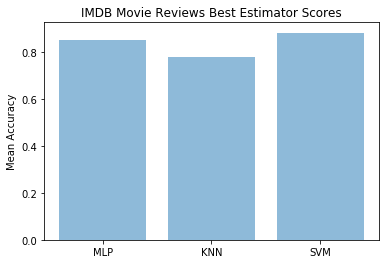

In [233]:
BarGraph(labels, datasets['IMDB'], "IMDB Movie Reviews", y_pos, y_label)

#### Dataset 2: Spam Text Messages 

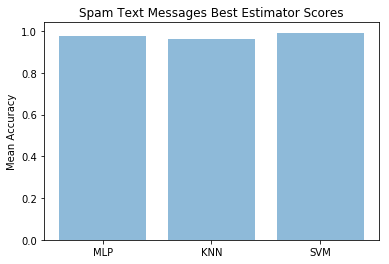

In [234]:
BarGraph(labels, datasets['spam'], "Spam Text Messages", y_pos, y_label)